In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/summarized/merged_summarized_fulltrain.csv
/kaggle/input/summarized/merged_summarized_test.csv


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Without summarization
train_data = pd.read_csv('/kaggle/input/4248-proj/raw_data/fulltrain.csv', header=None, names=['label', 'text'])
test_data = pd.read_csv('/kaggle/input/4248-proj/raw_data/balancedtest.csv', header=None, names=['label', 'text'])

# With summarization
# train_data = pd.read_csv('/kaggle/input/summarized/merged_summarized_fulltrain.csv', names=['text', 'label'])[1:]
# test_data = pd.read_csv('/kaggle/input/summarized/merged_summarized_test.csv',  names=['text', 'label'])[1:]

df_train, df_val = train_test_split(train_data, test_size=0.2, random_state=42)

X_train = df_train['text']
y_train = df_train['label']

X_val = df_val['text']
y_val = df_val['label']

X_test = test_data['text']
y_test = test_data['label']
print(test_data.head())
print(train_data.head())

                                                text label
1  Thats why Jeff Bridges made waves this week wh...     0
2  In what football insiders are calling an unexp...     0
3  In a freak accident following Game 3 of the N....     0
4  North Koreas official news agency announced to...     0
5  According to the poll, conducted by the Univer...     0
                                                text label
1  A little less than a decade ago, hockey fans w...     0
2  The writers of the HBO series The Sopranos too...     0
3  Despite claims from the TV news outlet to offe...     0
4  Maybe I was a little short with him when I tol...     0
5  'Well, it lets people see the teams they norma...     0


Text(0.5, 1.0, 'Test set distribution')

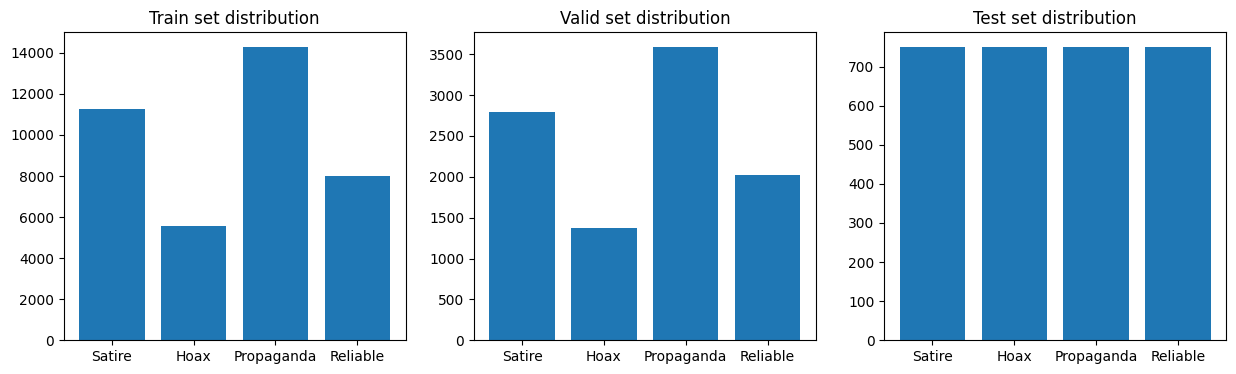

In [4]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))
ax[0].bar(["Satire","Hoax","Propaganda","Reliable"],df_train.groupby("label").count()["text"])
ax[0].set_title("Train set distribution")
ax[1].bar(["Satire","Hoax","Propaganda","Reliable"],df_val.groupby("label").count()["text"])
ax[1].set_title("Valid set distribution")
ax[2].bar(["Satire","Hoax","Propaganda","Reliable"],test_data.groupby("label").count()["text"])
ax[2].set_title("Test set distribution")

In [4]:
import tensorflow as tf
from transformers import (
    GPT2Tokenizer,
    GPT2ForSequenceClassification,
    TFGPT2ForSequenceClassification,
    AdamW,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    set_seed,
    get_linear_schedule_with_warmup
)
import torch
from torch.utils.data import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

2024-04-10 13:47:11.913256: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 13:47:11.913387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 13:47:12.175724: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
# Set seed for reproducibility.
set_seed(123)

MODEL_NAME = "gpt2"
MAX_LEN = 128
TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 64
NUM_EPOCHS = 2 # Best


device = "cuda" if torch.cuda.is_available() else "cpu"

label2id = {"Satire": 0, "Hoax": 1, "Propoganda": 2, "Reliable": 3}
id2label = {value: key for key, value in label2id.items()}

print(id2label) 
NUM_LABELS = len(label2id)

{0: 'Satire', 1: 'Hoax', 2: 'Propoganda', 3: 'Reliable'}


In [7]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00a 0:00:01


In [8]:
class CustomDataset(Dataset):
  def __init__(self, texts, labels, tokenizer):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    text = self.texts.iloc[idx].lower()
    label = int(self.labels.iloc[idx])

    # Apply preprocessing steps using the tokenizer
    encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=MAX_LEN)
    
    return {
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask'],
        'labels': label,
    }

import evaluate

acc = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return { 'accuracy': acc.compute(predictions=predictions, references=labels), 'f1': f1_metric.compute(predictions=predictions, references=labels, average="macro")}

In [10]:
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
tokenizer.padding_side = "left"
tokenizer.pad_token = '[PAD]'

model = GPT2ForSequenceClassification.from_pretrained(MODEL_NAME, pad_token_id=tokenizer.pad_token_id, num_labels = NUM_LABELS, id2label=id2label, label2id=label2id )
# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))
model.to(device)
print(device)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


In [19]:
train_dataset = CustomDataset(X_train, y_train, tokenizer)

val_dataset = CustomDataset(X_val, y_val, tokenizer)

test_dataset = CustomDataset(X_test, y_test, tokenizer)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [20]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    optim='adamw_torch',
    learning_rate=2e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    eval_accumulation_steps = 5,
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.149900,0.156536,{'accuracy': 0.9448367618462798},{'f1': 0.9398930522945559}
2,0.107300,0.144799,{'accuracy': 0.9520008187493604},{'f1': 0.9469411394366812}
3,0.085400,0.134900,{'accuracy': 0.9547640978405486},{'f1': 0.9508849098631125}
4,0.066500,0.135173,{'accuracy': 0.9559922218810767},{'f1': 0.9517770283217258}


Trainer is attempting to log a value of "{'accuracy': 0.9520008187493604}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9469411394366812}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Trainer is attempting to log a value of "{'accuracy': 0.9547640978405486}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1

TrainOutput(global_step=1224, training_loss=0.11289074841667623, metrics={'train_runtime': 2533.1024, 'train_samples_per_second': 61.716, 'train_steps_per_second': 0.483, 'total_flos': 1.0212445320118272e+16, 'train_loss': 0.11289074841667623, 'epoch': 4.0})

In [21]:
# model = GPT2ForSequenceClassification.from_pretrained('results/checkpoint-1222', pad_token_id=tokenizer.pad_token_id, num_labels = NUM_LABELS)

model.eval()
x = trainer.predict(test_dataset,  metric_key_prefix="predict")
print(x)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


PredictionOutput(predictions=array([[ 2.9631464e+00,  1.1960610e+01,  9.9198437e-01, -3.5716119e-01],
       [ 1.3763822e+00,  5.4001794e+00, -1.6365001e+00,  1.8796877e+00],
       [ 2.1192214e+00, -2.4970474e+00, -2.6582444e+00,  4.6331239e+00],
       ...,
       [-1.8971616e+00,  3.1001461e+00, -1.6263682e+00,  8.9365873e+00],
       [-9.1115147e-01, -2.6517732e+00, -9.9736822e-01,  6.4137635e+00],
       [-2.3003743e+00, -1.4424686e+00, -1.5026570e-03,  7.4671006e+00]],
      dtype=float32), label_ids=array([0, 0, 0, ..., 3, 3, 3]), metrics={'predict_loss': 2.462440252304077, 'predict_accuracy': {'accuracy': 0.542}, 'predict_f1': {'f1': 0.5248386898631335}, 'predict_runtime': 20.2281, 'predict_samples_per_second': 148.309, 'predict_steps_per_second': 1.186})


In [22]:
y_pred = np.argmax(x.predictions, axis = 1)
print(y_pred)

[1 1 3 ... 3 3 3]


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.50      0.62       750
           1       0.60      0.47      0.53       750
           2       0.29      0.24      0.26       750
           3       0.54      0.96      0.69       750

    accuracy                           0.54      3000
   macro avg       0.56      0.54      0.52      3000
weighted avg       0.56      0.54      0.52      3000


Confusion Matrix:


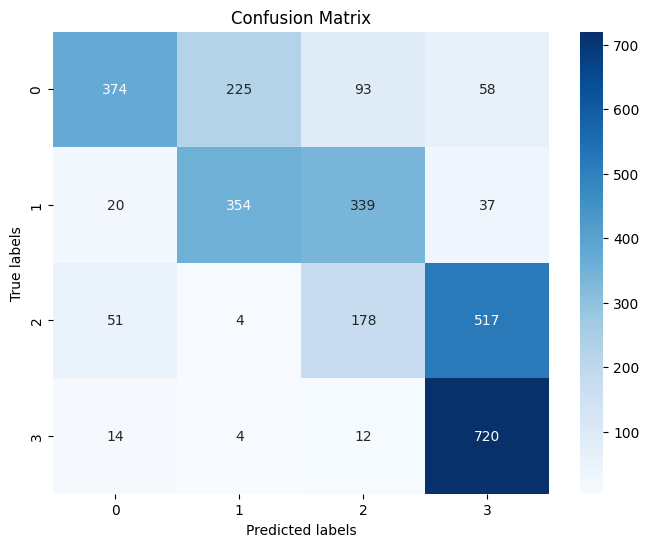

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))


# Print the confusion matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
